# pyPCGA modflow inversion example

Requirements : Flopy (tested in ver 3.2.9)

For Flopy installation and execution, please see http://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/schedule.html

 

## Crosswell tomography

- Adapted from Application 1 of Lee and Kitanids [WRR 2014] 

(https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR015483)

***

> We first generated 870 head observations using crosswell pumping tests (ln 9) from the reference log K field (ln 11) with USGS MODFLOW Flopy python interface.

> In specific, we extracted groundwater at a well and observed 29 stready-state hydraulic heads at the remaining monitoring wells. We repeated these crosswell pumping tests for all 30 well locations (ln 11).  

> Then add the noise (std = 0.5) to observations. Using observations with MODFLOW, can we reconstruct the reference field (ln 11)?

Note the example is not exactly same as Application 1 in Lee and Kitanidis [2014]

Also, the number of MODFLOW simulations is higher than what they reported because we turned on Levenberg-Marquardt and Line Search options in this example. Those additional optimization routines increases the inversion time, but usually results in a very accurate inverse solution even for highly nonlinear problems. 

***

- Parameters

|Description           |                      |   Value |            
|----------------------|:----------------------------------:|:---------------------------:|
|*Geomteric parameters*                          | |       |                                               
| Lx, Ly        | Domain length and width (m)        |        1000, 750|         
| Q             | Pumping rates (m^2/d)              |            25 |           
| Rch           | Recharge rates (m/d)               |           0.001|          
| dx, dy        | Grid size (m)                      |            10|            
|*Geostatistical parameters*     ||                      |                        
| reference mean(logK)    | mean for the reference log K (ln m/d) |            2.5  |          
| reference q(x,x')       | Covariance kernel for the reference log K                  | q(x,x') = 0.002^3 (x-x')^3 |
| q(x,x')            | Covariance kernel used in inversion | q(x,x') = exp(-x/250) |
|*Measurement Error* ||  |
| nobs | Number of measurement | 870 |
| R | Variance of measurement error (m) | 0.5^2 |


In [1]:
import copy
import logging
import os
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np  # need 1.21 at least
import pandas as pd
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from matplotlib.colors import LogNorm
from pyrtid.utils import (
    NDArrayFloat,
    indices_to_node_number,
    node_number_to_indices,
)
from scipy import ndimage


- Check package/software versions

In [ ]:
pyrtid.utils.show_versions()

- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Set-up logging level

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Define some configurations for the plots

In [6]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()
plt.rcParams.update(new_rc_params)

# Problem definition

- Grid definition

In [7]:
nx = 22
ny = 11
nz = 1
dx = 10  # m
dy = 10  # m
dz = 1

- Location of pumping wells (obs_locmat)

In [8]:
obs_locmat = np.zeros((nz, ny, nx), dtype=bool)
obs_locs: List[Tuple[int, int]] = []
# for i in range(5, 71, 16):  # y
#    for j in range(9, 96, 16):  # x
for i, j in [(5, 6), (5, 14)]:
    obs_locmat[0, i, j] = 1
    obs_locs.append((j, i))

Q_locs_idx = np.where(obs_locmat == True)
Q_locs = []
for Q_loc in zip(Q_locs_idx[0], Q_locs_idx[1], Q_locs_idx[2]):
    Q_locs.append(Q_loc)

- x,y coordinates for plotting

In [9]:
x = np.linspace(0.0 + dx / 2.0, nx * dx - dx / 2.0, nx)
y = np.linspace(0.0 + dy / 2.0, ny * dy - dy / 2.0, ny)
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

- Pumping/monitoring well locations

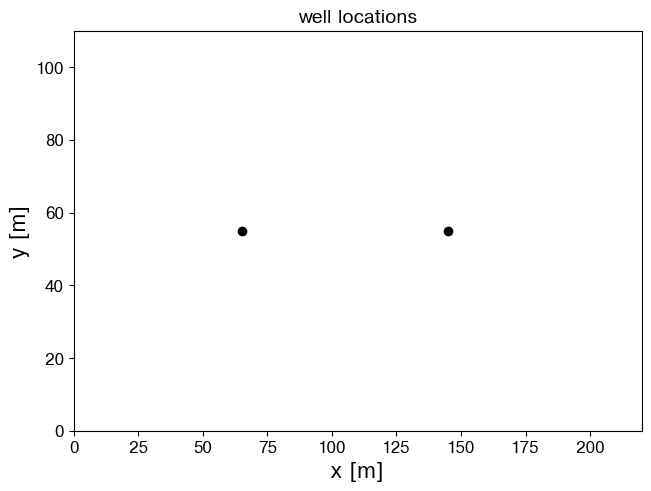

In [10]:
idx = np.where(obs_locmat == 1)
for i, j in zip(idx[1], idx[2]):
    plt.plot(x[j], y[i], "ko")
plt.xlim(0, nx * dx)
plt.ylim(0, ny * dy)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("well locations")

fname = "well_locations"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- This example is Hydraulic tomography - crosswell pumping test setting
- Load reference value for comparison purpose with its plot

Note: in HYTEC, we can adjust the permeability, so we need to convert these values to permeability ones



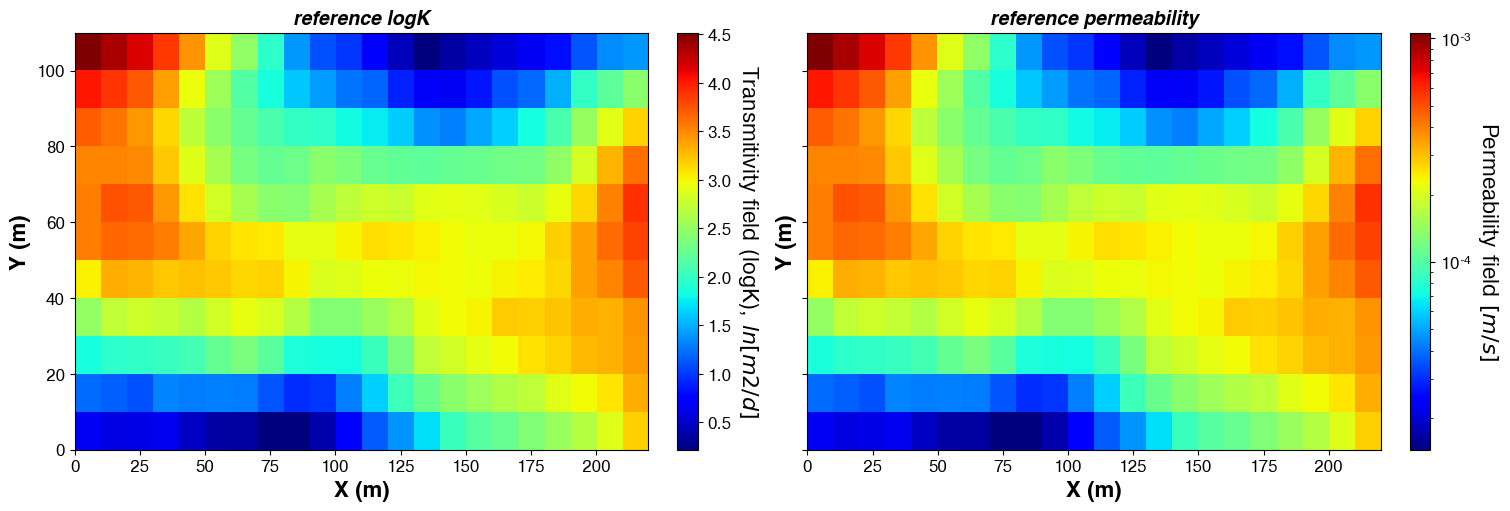

In [11]:
def log_transmitivity_to_permeability(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a transmitivity in ln[m2/d] to a permeability in [m/s]."""
    return np.exp(x) / 3600 / 24


def permeability_to_log_transmitivity(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a permeability in [m/s] to a transmitivity in ln[m2/d]."""
    return np.log(x * 3600 * 24)


logT_reference: NDArrayFloat = np.loadtxt("reference_logK.txt").reshape(75, 100).T

# resample from 100 x 75 to nx * ny
_XX, _YY = np.meshgrid(np.linspace(0.0, 100 - 1, nx), np.linspace(0, 75 - 1, ny))
_pts = np.hstack((_XX.ravel()[:, np.newaxis], _YY.ravel()[:, np.newaxis]))

logT_reference_2d = (
    ndimage.map_coordinates(logT_reference, coordinates=_pts.T).reshape(ny, nx).T
)
perm_reference_2d = log_transmitivity_to_permeability(logT_reference_2d)

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-1")],
    fig=plotter.fig,
    data={"reference logK": logT_reference_2d},
    cbar_title="Transmitivity field (logK), $ln[m2/d]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-2")],
    fig=plotter.fig,
    data={"reference permeability": perm_reference_2d},
    cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "norm": LogNorm(),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

- Set some variable for the tests

In [12]:
crank_nicolson = 1.0  # enough to ensure stability and test "semi-implcit"
flow_regime = "transient"
cst_head_left = 120  # m
cst_head_right = 110  # m
dt_in_days = 0.25
duration_in_days = 3

# Forward problem in the demonstrator

- Creation of a base model

In [13]:
dt = 3600 * 24 * dt_in_days
nt = int(duration_in_days * 3600 * 24 / dt) + 1
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy)
fl_params = dmfwd.FlowParameters(
    permeability=8.0e-5,
    storage_coefficient=1e-3,
    regime={
        "stationary": dmfwd.FlowRegime.STATIONARY,
        "transient": dmfwd.FlowRegime.TRANSIENT,
    }[flow_regime],
    crank_nicolson=crank_nicolson,  # For the check, semi-implicit scheme
)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params)

- Add boundary conditions and regional recharge

In [14]:
# Add a regional recharge -> 35 m3/d = 35 / 3600 / 24 m3/s
flw_reg = 25.0 / 3600 / 24
recharge_source = dmfwd.SourceTerm(
    "aquifer_recharge",
    node_ids=np.arange(nx * ny),  # -> on the full domain
    times=np.arange(time_params.nt) * time_params.dt,
    flowrates=np.repeat(flw_reg, time_params.nt),
    concentrations=np.repeat(0.0, time_params.nt),
)
base_model.add_src_term(recharge_source)

# Boundary conditions
# Left border (x = 0) at 120 m
base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
base_model.fl_model.head[0, :, :] = cst_head_left
# Right border (x = xmax) at 110 m
base_model.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
base_model.fl_model.head[-1, :, :] = cst_head_right

- Create the source terms for the pumping: one pumping test per day at -25 m3/h

In [15]:
n_step_per_day = int(1 / dt_in_days)
for day in range(0, 2):
    ix, iy = obs_locs[day]
    source_term = dmfwd.SourceTerm(
        "well pumping test # {day}",
        node_ids=np.array(
            indices_to_node_number(ix=ix, nx=nx, iy=iy, ny=ny)
        ),  # -> on the full domain
        times=np.array(
            (day * n_step_per_day + np.arange(n_step_per_day) + 1) * time_params.dt
        ),
        flowrates=np.array([-25.0 / 3600] * n_step_per_day),
        concentrations=np.array(0.0),
    )
    base_model.add_src_term(source_term)

- Check that the sources have been correctly defined: we plot the flowrate within time for the 30 wells: we see 30 intervals

In [16]:
span = node_number_to_indices(np.arange(nx * ny), nx=nx, ny=ny)[:-1]
src = base_model.get_fl_sources()

Text(0, 0.5, 'flowrates [m3/s]')

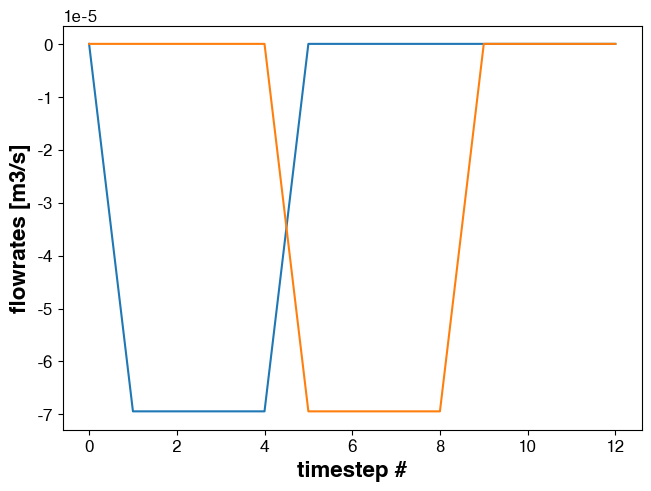

In [17]:
fl_sources = base_model.get_fl_sources()
fig, ax = plt.subplots()
for i in range(len(obs_locs)):
    ix, iy = obs_locs[i]
    ax.plot(fl_sources[ix, iy, :])
ax.set_xlabel("timestep #", fontweight="bold")
ax.set_ylabel("flowrates [m3/s]", fontweight="bold")

- Create two models with different permeabilities

In [18]:
# copy the base model
model_reference = copy.deepcopy(base_model)
# update permeability
model_reference.fl_model.permeability = perm_reference_2d
# solve the flow problem
dmfwd.ForwardSolver(model_reference).solve()

In [19]:
# copy the base model
model_estimate = copy.deepcopy(base_model)
# update permeability
model_estimate.fl_model.permeability[:, :] = log_transmitivity_to_permeability(1.0)
# solve the flow problem
dmfwd.ForwardSolver(model_estimate).solve()

# Forward problem in HYTEC

- Define a runner

In [20]:
if runner_type == RunnerType.FRONTAL:
    runner = FrontalHytecRunner(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        nb_cpu=4,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.SLURM:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=12,
        queue="geo-cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = SlurmHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.QSUB:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=12,
        queue="Omines_cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = QsubHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
else:
    raise Exception("Could not created runner")

- Create an empty simulation in a non existing folder

In [21]:
simu_base = HytecSimulation("simu_base", Path.cwd().joinpath("simu_base"))

- Add a TDB file

In [22]:
simu_base.link_tdb("./../../../../TDB/chess.tdb")  # This is relative to the htc file

- Define the output format

In [23]:
simu_base.model.add_sub_item(hymd.OutputFormat("vtk"))

- Hydrodynamic model and its parameters definition


In [24]:
hmodel = hymd.HydrodynamicModel(
    hymd.FlowRegime(flow_regime),
    hymd.Porosity(0.23),
    hymd.Permeability(8e-5, units="m/s"),
    hymd.DiffusionCoefficient(1e-4, units="m2/s"),
    hymd.Head(0.0, "m"),
    hymd.StorageCoefficient(1e-3),
    hymd.FlowCrankNicolson(crank_nicolson),
)
simu_base.model.add_sub_item(hmodel)

- Geochemical unit definition

In [25]:
chmodel = hymd.GeochemicalModel(hymd.Report("full"), hymd.Redox("disabled"))
# Define a geochem unit
base_unit = hymd.GeochemicalUnit("chem_base")
species = "T"
# Set concentrations
base_unit.add_sub_item(hymd.Concentration(species, 0.0, units="molal"))
# define tracer
chmodel.add_sub_item(hymd.Define("basis", species))

# exclude
chmodel.add_sub_item(hymd.Exclude(("minerals", "colloids", "gases")))

# Add the units to the geochemical model
chmodel.add_sub_item(base_unit)

# Add to the main model
simu_base.model.add_sub_item(chmodel)

- Geometry definition

In [26]:
gmodel = hymd.GeometryModel(
    hymd.GridRegime("rectangle"), hymd.Domain(f"{nx*dx},{nx} {ny*dy},{ny}")
)
zone_domain = hymd.Zone(
    "domain", hymd.Geometry("domain"), hymd.Geochemistry(base_unit.name)
)
gmodel.add_sub_item(zone_domain)
simu_base.model.add_sub_item(gmodel)

- Boundary model definition

In [27]:
flc_left = hymd.FlowCondition(f"constant-head at {cst_head_left} m")
flc_right = hymd.FlowCondition(f"constant-head at {cst_head_right} m")
bmodel = hymd.BoundaryModel(
    hymd.Boundary(
        "border_left", hymd.Coordinates(f"0,0, 0,{ny*dy}", units="m"), flc_left
    ),
    hymd.Boundary(
        "border_right",
        hymd.Coordinates(f"{nx*dx},{ny*dy}, {nx*dx},0", units="m"),
        flc_right,
    ),
)
simu_base.model.add_sub_item(bmodel)

- Time discretization

In [28]:
tmodel = hymd.TimeDiscretizationModel(
    hymd.Duration(duration_in_days, units="d"),
    hymd.TimeStep(
        hymd.Variable(
            hymd.StartValue(dt_in_days, "d"),
            hymd.Maximum(dt_in_days, "d"),
            hymd.CourantFactor(10000.0),
        ),
    ),
)
simu_base.model.add_sub_item(tmodel)

- Sampling definition

In [29]:
# Sampling model
smodel = hymd.SamplingModel(
    hymd.GridSampling(int(duration_in_days / dt_in_days)),
    hymd.Select("time", units="d"),
    hymd.Select("node-number"),
    hymd.Select("flowrate", units="m/s"),
    hymd.Select("permeability", units="m/s"),
    hymd.Select("head", units="m"),
    hymd.Select("T", units="mol/kg"),
)
simu_base.model.add_sub_item(smodel)

- Add a source term on the domain: aquifer recharge

In [30]:
zone_domain.add_sub_item(hymd.Source(25, "m3/d", geochem_unit=base_unit.name))

- Create the injection/pumping file: Only one well inject per day: 30 columns with 30 days + 1 column for the time (days) + 1 row for day 0 before any pumping

In [31]:
src_term_path: str = "MODIFY/source_terms.dat"
src_term_data: NDArrayFloat = np.zeros((len(obs_locs) + 2, len(obs_locs) + 1))
src_term_data[:, 0] = np.arange(len(obs_locs) + 2)

# Fill the diagonal with the pumping
# src_term_data[0, 1] = -25
for i in range(len(obs_locs)):
    src_term_data[i, i + 1] = -25

# Add the aquifer recharge -> 1000 m3/d on the domain = 1000 / 7500 / 24 at the well

src_term_data[:, 1:] += 25 / nx / ny / 24
src_term_data

array([[ 0.00000000e+00, -2.49956956e+01,  4.30440771e-03],
       [ 1.00000000e+00,  4.30440771e-03, -2.49956956e+01],
       [ 2.00000000e+00,  4.30440771e-03,  4.30440771e-03],
       [ 3.00000000e+00,  4.30440771e-03,  4.30440771e-03]])

In [32]:
# Add the producers with an imposed pumping of 25 m3/d
for count, (i, j) in enumerate(obs_locs):
    x = (i + 0.5) * dx
    y = (j + 0.5) * dy
    name = f"Producer_{i:0>2d}_{j:0>2d}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {x},{y}, {dx/2},{dy/2}",
            units="m",
        )
    )
    value = src_term_data[0, count + 1]
    print(value)
    zone.add_sub_item(hymd.Geochemistry(base_unit.name))
    zone.add_sub_item(hymd.GlobalFlux(name))
    zone.add_sub_item(hymd.Source(value, units="m3/h", geochem_unit=base_unit.name))
    zone.add_sub_item(
        hymd.Modify(
            "$1",
            hymd.Source(
                f"${count+2}",
                units="m3/h",
                geochem_unit=base_unit.name,
                src_file_path=src_term_path,
            ),
            time_units="d",
        )
    )
    simu_base.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)

# 3) Add the src_data_file (need to write and read the file... which is a bit stupid...)
# Register the source data file
simu_base.register_modifiy_src_file(src_term_path, src_term_data, fmt="%.3f")

-24.995695592286502
0.004304407713498623


- Create two models from this base simulation

In [33]:
simu_reference = copy.deepcopy(simu_base)
simu_reference.update_root_and_name(
    new_root="simu_reference", new_name="simu_reference"
)
simu_estimate = copy.deepcopy(simu_base)
simu_estimate.update_root_and_name(new_root="simu_estimate", new_name="simu_estimate")

- Add the permeability fields to the simulations

In [34]:
index: NDArrayInt = np.arange(nx * ny)

# True
data_true = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "y": sorted((index % ny) * dy + dy / 2),
        "permeability": perm_reference_2d.ravel("F"),
    },  # need to flatten the parameter
    index=index,
)
simu_reference.add_param_file_data(ParameterFiles.HYDRO, data_true)

# Estimated
data_estimated = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "y": sorted((index % ny) * dy + dy / 2),
        "permeability": log_transmitivity_to_permeability(np.array([1.0])),
    },  # need to flatten the parameter
    index=index,
)
simu_estimate.add_param_file_data(ParameterFiles.HYDRO, data_estimated)

- Checking the hydro parameters have been correctly set-up

In [35]:
with pd.option_context("display.max_rows", 10):
    print(simu_reference.handlers.hydro.data)

     node-number      x      y  permeability
0              0    5.0    5.0      0.000022
1              1   15.0    5.0      0.000021
2              2   25.0    5.0      0.000021
3              3   35.0    5.0      0.000022
4              4   45.0    5.0      0.000019
..           ...    ...    ...           ...
237          237  175.0  105.0      0.000022
238          238  185.0  105.0      0.000026
239          239  195.0  105.0      0.000036
240          240  205.0  105.0      0.000045
241          241  215.0  105.0      0.000047

[242 rows x 4 columns]


In [36]:
with pd.option_context("display.max_rows", 10):
    print(simu_estimate.handlers.hydro.data)

     node-number      x      y  permeability
0              0    5.0    5.0      0.000031
1              1   15.0    5.0      0.000031
2              2   25.0    5.0      0.000031
3              3   35.0    5.0      0.000031
4              4   45.0    5.0      0.000031
..           ...    ...    ...           ...
237          237  175.0  105.0      0.000031
238          238  185.0  105.0      0.000031
239          239  195.0  105.0      0.000031
240          240  205.0  105.0      0.000031
241          241  215.0  105.0      0.000031

[242 rows x 4 columns]


In [37]:
simu_reference.handlers.modify_files.keys()

dict_keys([PosixPath('MODIFY/source_terms.dat')])

- Write input files and run simulations

In [38]:
simu_reference.write_input_files()
simu_estimate.write_input_files()
runner.run(simu_reference)
runner.run(simu_estimate)

The job is over ! Elapsed time = 0:00:00.117971
The job is over ! Elapsed time = 0:00:00.100847


True

- Read results

In [39]:
# Reference
simu_reference.read_hytec_results()
perm_reference_hytec: NDArrayFloat = (
    simu_reference.handlers.results.extract_field_from_grid_res(
        field="permeability [m/s]", nx=nx, ny=ny
    )[:, :, 0, 0]
)
head_reference_hytec: NDArrayFloat = (
    simu_reference.handlers.results.extract_field_from_grid_res(
        field="head [m]", nx=nx, ny=ny
    )[:, :, 0, :]
)

# Initial guess
simu_estimate.read_hytec_results()
perm_estimate_hytec: NDArrayFloat = (
    simu_estimate.handlers.results.extract_field_from_grid_res(
        field="permeability [m/s]", nx=nx, ny=ny
    )[:, :, 0, 0]
)
head_estimate_hytec: NDArrayFloat = (
    simu_estimate.handlers.results.extract_field_from_grid_res(
        field="head [m]", nx=nx, ny=ny
    )[:, :, 0, :]
)

grid_obs_times = simu_estimate.handlers.results.get_sample_times_from_grid_res()

- Check that the permeability has been correctly defined in HYTEC (we see that from the grid results)

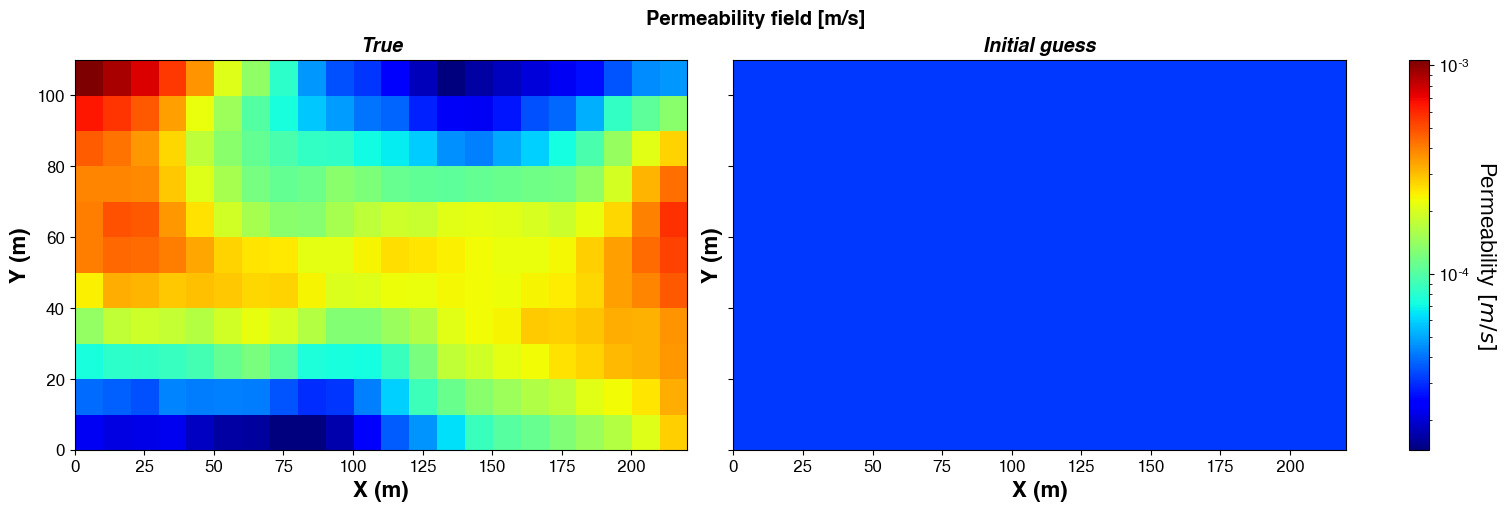

In [40]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.get_axis(ax_name) for ax_name in ["ax1-1", "ax1-2"]],
    fig=plotter.fig,
    data={"True": perm_reference_hytec, "Initial guess": perm_estimate_hytec},
    cbar_title="Permeability $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "norm": LogNorm(),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.subfigs["fig0"].suptitle("Permeability field [m/s]", fontweight="bold")

fname = "perm_field_reference_vs_init"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

# Forward model comparison

In [41]:
model_estimate.fl_model.head.shape

(22, 11, 13)

- Plot the first sample (to see the boundary conditions)

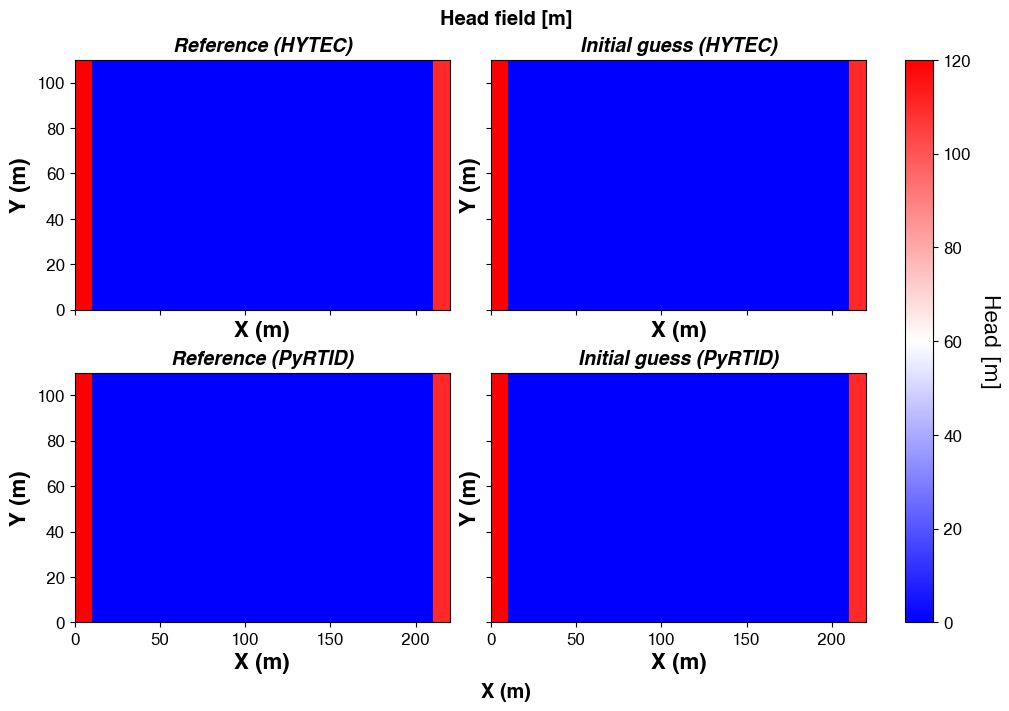

In [42]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 7)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"]], sharey=True, sharex=True
        )
    },
)

frame_id = 0
ngp.multi_imshow(
    axes=plotter.axes,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (HYTEC)": head_reference_hytec[:, :, frame_id],
        "Initial guess (HYTEC)": head_estimate_hytec[:, :, frame_id],
        "Reference (PyRTID)": model_reference.fl_model.head[:, :, frame_id],
        "Initial guess (PyRTID)": model_estimate.fl_model.head[:, :, frame_id],
    },
    fig=plotter.fig,
    cbar_title="Head [m]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

fname = "head_field_reference_vs_initial_guess"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Make an animated version

In [43]:
head_reference_hytec.shape

(22, 11, 13)

In [44]:
model_reference.fl_model.head.shape

(22, 11, 13)

- PyRTID and HYTEC give strictly identical results 

In [45]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 7)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"]], sharey=True, sharex=True
        )
    },
)

nb_frames = head_reference_hytec.shape[-1]
plotter.animated_multi_imshow(
    ax_names=list(plotter.ax_dict.keys()),
    data={
        # Warning: observation 0 matches sample 1
        "Reference (HYTEC)": head_reference_hytec[:, :, :],
        "Initial guess (HYTEC)": head_estimate_hytec[:, :, :],
        "Reference (PyRTID)": model_reference.fl_model.head[:, :, :],
        "Initial guess (PyRTID)": model_estimate.fl_model.head[:, :, :],
    },
    cbar_title="Head [m]",
    nb_frames=nb_frames,
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Compare the data from HYTEC and PyRTID at the observation wells

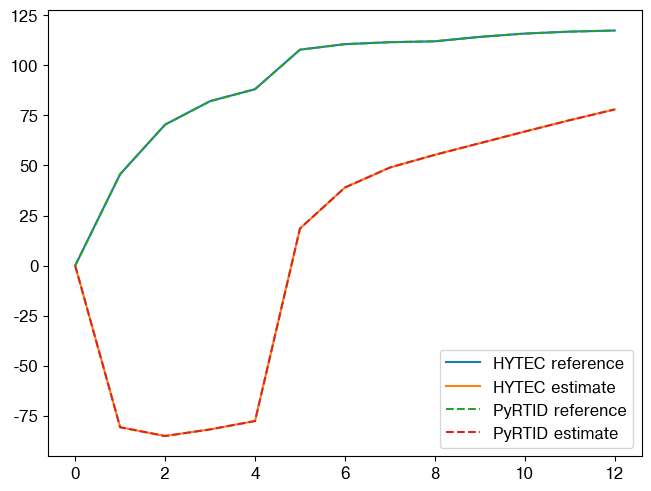

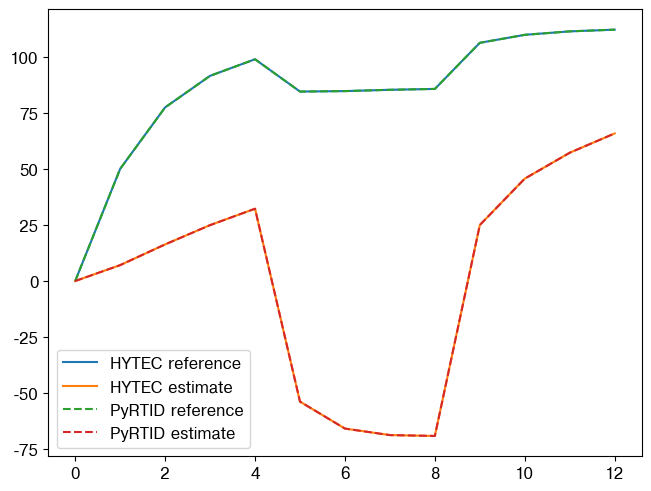

<Figure size 640x480 with 0 Axes>

In [46]:
pumping_test_id = 2  # index of the well pumping test

dat_hytec_reference: NDArrayFloat = np.zeros(
    (len(obs_locs), head_reference_hytec.shape[-1])
)
dat_hytec_estimate: NDArrayFloat = np.zeros(
    (len(obs_locs), head_reference_hytec.shape[-1])
)

for i, obs_loc in enumerate(obs_locs):
    dat_hytec_reference[i, :] = head_reference_hytec[obs_loc[0], obs_loc[1], :]
    dat_hytec_estimate[i, :] = head_estimate_hytec[obs_loc[0], obs_loc[1], :]

    plt.plot(dat_hytec_reference[i, :], label="HYTEC reference")
    plt.plot(dat_hytec_estimate[i, :], label="HYTEC estimate")
    plt.plot(
        model_reference.fl_model.head[obs_loc[0], obs_loc[1], :],
        label="PyRTID reference",
        linestyle="--",
    )
    plt.plot(
        model_estimate.fl_model.head[obs_loc[0], obs_loc[1], :],
        label="PyRTID estimate",
        linestyle="--",
    )
    plt.legend()
    plt.show()

fname = f"heads_modflow_vs_hytec_for_pumping_test_{pumping_test_id}"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Observable selections

- Create a function to add some noise to the observations

In [47]:
noise_std = 0.5  # This is an absolute value -> 0.3 m std for the head
rng = np.random.default_rng(2021)


def make_noisy(x: np.ndarray) -> np.ndarray:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return x + rng.normal(mean_noise, noise_std, x.shape)

- Add the observation data at the wells positions


In [48]:
first_obs_day = 10
last_obs_day = 12

In [49]:
i, j = obs_locs[1]
head_reference_hytec[i, j, first_obs_day:last_obs_day]

array([110.03417606, 111.57558097])

In [50]:
obs_timesteps = grid_obs_times[first_obs_day:last_obs_day]
obs_timesteps

array([2.5 , 2.75])

In [51]:
2.75 * 3600 * 24

237600.0

# Gradient calculation PyRTID

- Define observables: take one mesure per day

In [52]:
observables: List[Observable] = []
for count, (i, j) in enumerate(obs_locs):
    vals = model_reference.fl_model.head[i, j, first_obs_day:last_obs_day]
    observables.append(
        dminv.Observable(
            state_variable=dminv.StateVariable.HEAD,
            location=(slice(i, i + 1), slice(j, j + 1)),
            timesteps=np.arange(first_obs_day, last_obs_day),
            values=vals,
            uncertainties=noise_std,
        )
    )

- Create a simulation for inversion based

In [53]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    lbounds=1e-6,
    ubounds=0.1,
    preconditioner=dminv.LogTransform(),
)

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 10, "maxiter": 10, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    max_fun_per_round=10,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

is_grad_ok = executor.is_adjoint_gradient_correct()
print("Is the gradient correct: ", is_grad_ok)

Is the gradient correct:  True


In [87]:
# Need to compute the objective function
pyrtid_obj_fun = executor.eval_scaled_loss(param.preconditioner(param.values))
pyrtid_obj_fun

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 22851.544912039335
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 4.376071744160939e-05
INFO:root:Loss (scaled)         = 1.0



1.0

# Gradient calculation HYTEC

- Copy the base estimate

In [54]:
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

In [55]:
for count, (i, j) in enumerate(obs_locs):
    x = (i + 0.5) * dx
    y = (j + 0.5) * dy
    zone_name = f"Producer_{i:0>2d}_{j:0>2d}"

    vals = make_noisy(head_reference_hytec[i, j, first_obs_day:last_obs_day])
    # vals[count + 1] = np.nan

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable="head",
        units="m",
        timesteps=grid_obs_times[first_obs_day:last_obs_day],
        time_units="d",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.ones(vals.size)
        * indices_to_hytec_node_number(ix=i, nx=nx, iy=j),
    )
    simu_inverse.register_observable(
        zone_name,
        obs,
        obs_file_path=f"observables/{zone_name}_o.dat",
        is_overwrite_handler=True,
    )

- Check that the observations have been correctly passed to the estimated model 

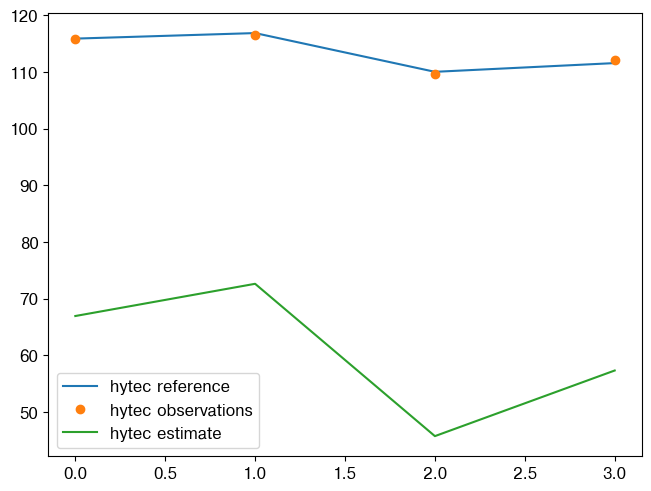

In [56]:
# Observation vector from HYTEC -> transform it to achieve PCGA expected shape
obs_hytec_reference: NDArrayFloat = (
    simu_inverse.get_observation_vector()
)  # .reshape(len(simu_estimate.get_adjustable_parameters()), -1).T.ravel()
res_hytec_reference: NDArrayFloat = simu_reference.get_results_matching_obs_vector(
    simu_inverse.get_observables()
)
res_hytec_estimate: NDArrayFloat = simu_estimate.get_results_matching_obs_vector(
    simu_inverse.get_observables()
)

well_id = 1  # indew of the well we look at

plt.plot(res_hytec_reference.ravel(), label="hytec reference")
plt.plot(
    obs_hytec_reference.ravel(),
    label="hytec observations",
    linestyle="none",
    marker="o",
)
plt.plot(res_hytec_estimate.ravel(), label="hytec estimate")
plt.legend()

- Compute the objective function

In [57]:
obs_hytec_reference

array([115.859031  , 116.52666045, 109.63993266, 112.11358439])

In [58]:
grid_obs_times * 3600 * 24

array([     0.,  21600.,  43200.,  64800.,  86400., 108000., 129600.,
       151200., 172800., 194400., 216000., 237600., 259200.])

In [59]:
res_hytec_estimate

array([66.95555691, 72.6391352 , 45.76696858, 57.34361359])

In [60]:
((obs_hytec_reference - res_hytec_estimate) / noise_std) ** 2

array([ 9566.19911299,  7704.45949233, 16319.0221645 , 11998.99880662])

In [61]:
obj = 1 / 2 * np.sum(np.square((obs_hytec_reference - res_hytec_estimate) / noise_std))
logging.info(f"objective function (SSE)= {obj}")

INFO:root:objective function (SSE)= 22794.33978822084


- Create a simulation for inversion and compute the first gradient

In [62]:
# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb",
        hymd.AdjointStateStatus("enabled"),
        hymd.MaxNumberIterations(1),
        hymd.MaxNumberGradientEval(1),
        hymd.MaxNumberFwdModelEval(1),
        hymd.FdGradientCheck("initial"),
    ),
    hymd.AdjustedParameterConfig(
        "permeability",
        hymd.Lbound(1e-6, units="m/s"),
        hymd.Ubound(1e-1, units="m/s"),
        hymd.Preconditioner("logarithmic"),
    ),
)
simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    # TODO: find why there is a bug if we set 5 and less ???
    hymd.AdjointGridSampling(10)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

The job is over ! Elapsed time = 0:00:18.658980


- Extract the adjoint variables computed for the first gradient

In [63]:
print(f"columns = {simu_inverse.handlers.results.optim_res.adjoint_var_columns}")

columns = ['timestep', 'Zones', 'node-number []', 'adjoint-variable{head} []', 'x-distance', 'y-distance']


In [64]:
adj_head_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{head} []", nx=nx, ny=ny
)
adj_head_hytec.shape

(22, 11, 1, 11)

# Adjoint head and gradient comparison

In [69]:
head_estimate_hytec.shape

(22, 11, 13)

In [68]:
model_estimate.fl_model.head.shape

(22, 11, 13)

In [65]:
adj_head_hytec.shape

(22, 11, 1, 11)

In [66]:
executor.adj_model.a_fl_model.a_head.shape

(22, 11, 13)

- Plot the adjoint head

In [70]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

nb_frames = adj_head_hytec.shape[-1]

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    data={
        "Adjoint head (HYTEC)": adj_head_hytec[:, :, 0, :],
        "Adjoint head (PyRTID)": executor.adj_model.a_fl_model.a_head[:, :, :-2],
    },
    cbar_title="Adjoint head",
    nb_frames=nb_frames,
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.fig.suptitle("Adjoint head", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("adjoint_head_field_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Plot the first gradient

In [71]:
hytec_fd_gradient = (
    simu_inverse.handlers.results.optim_res.fd_gradients[0]["value"]
    .to_numpy()
    .reshape(ny, nx)
)
hytec_adjoint_gradient = (
    simu_inverse.handlers.results.optim_res.adjoint_gradients[0]["value"]
    .to_numpy()
    .reshape(ny, nx)
)
residuals = hytec_fd_gradient - hytec_adjoint_gradient

In [91]:
pyrtid_fd_gradient = (
    param.grad_fd_history[0].reshape(nx, ny) * executor.inv_model.scaling_factor
)
pyrtid_adjoint_gradient = (
    param.grad_adj_history[0].reshape(nx, ny) * executor.inv_model.scaling_factor
)
pyrtid_grad_residuals = pyrtid_fd_gradient - pyrtid_adjoint_gradient

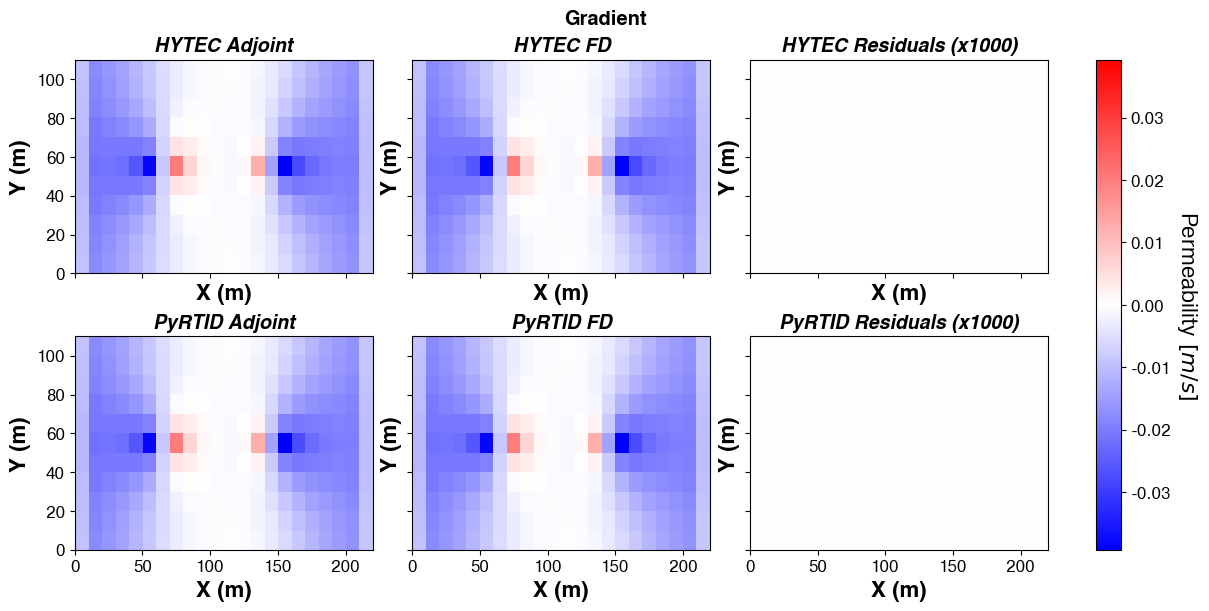

In [92]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3"], ["ax2-1", "ax2-2", "ax2-3"]],
            sharey=True,
            sharex=True,
        )
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "HYTEC Adjoint": hytec_adjoint_gradient.T,
        "HYTEC FD": hytec_fd_gradient.T,
        "HYTEC Residuals (x1000)": residuals.T * 1000,
        "PyRTID Adjoint": pyrtid_adjoint_gradient,
        "PyRTID FD": pyrtid_fd_gradient,
        "PyRTID Residuals (x1000)": pyrtid_grad_residuals * 1000,
    },
    cbar_title="Permeability $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("bwr"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
    is_symmetric_cbar=True,
)

plotter.subfigs["fig0"].suptitle("Gradient", fontweight="bold")

fname = "gradient_fd_vs_adjoint"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

# Inversion with regularization

TODO 